My friend asked me if I can figure out the breed of his dog, Loki. 
As I am not a dog expart, I will ask opinions from deep learning. Here, I use VGG16 trained on [ImageNet](http://www.image-net.org/) dataset.

#### What is VGG16 and ImageNet?
According to [Wikipedia](https://en.wikipedia.org/wiki/ImageNet), 

_"The ImageNet project is a large visual database designed for use in visual object recognition software research...Since 2010, the annual ImageNet Large Scale Visual Recognition Challenge (ILSVRC) is a competition where research teams evaluate their algorithms on the given data set, and compete to achieve higher accuracy on several visual recognition tasks."_ 

The good think about this dataset is that it contains 120 categories of dog breeds. So the fine tuned model in this data should be able to classify Loki to the right breed!

**VGG16** (also called OxfordNet) is a convolutional neural network architecture named after the [Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/research/very_deep/) from Oxford, who developed it. It was used to win the ILSVR (ImageNet) competition in 2014.




In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
print(tf.__version__)
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "2"
#### 1 GPU1
#### 2 GPU2
#### 0 GPU3
#### 4 GPU4
set_session(tf.Session(config=config))

Using TensorFlow backend.


1.2.1


My data folder contains 6 images of Loki. Load them into python and save them as a numpy array. The image is converted into 3 dimentional numpy array by the method "img_to_array"

In [4]:
ls data/

IMG-20180108-WA0004.jpg*       WP_20150225_15_18_47_Pro.jpg*
IMG-20180122-WA0003.jpg*       WP_20171222_09_09_22_Pro.jpg*
WP_20150225_14_59_57_Pro.jpg*  WP_20180120_12_00_15_Pro.jpg*


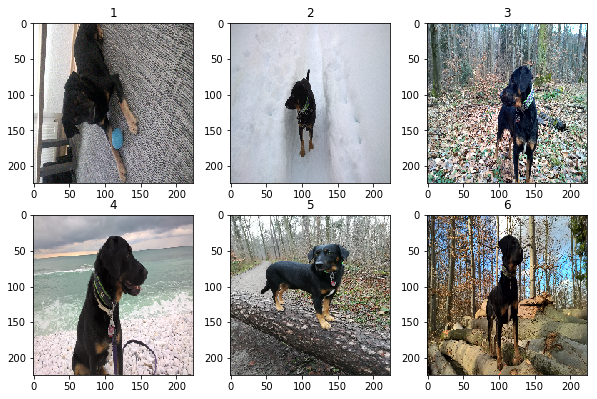

In [5]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

pic_nms = os.listdir("data/")

fig = plt.figure(figsize=(10,10))
count = 1
myimages = []
for pic_nm in pic_nms:
    axs = fig.add_subplot(3,len(pic_nms)/2,count)
    image = load_img('data/'+pic_nm, target_size=(224, 224,3))
    axs.imshow(image)
    axs.set_title(count)
    
    image = img_to_array(image) 
    myimages.append(image)
    count += 1
plt.show()


The picture 1 needs to be rotated by 90 degree. 
For rotating picture, I use opencv. Nicely, pip was available for installation:

```python
pip install opencv-python
```



In [6]:
import cv2
print(cv2.__version__)

3.4.0


In [7]:
def rotateImage(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result
image = rotateImage(myimages[0], 270)

Let's check if the image is correctly rotated. 

Here we have to be careful. The image array converted from the img_to_array has a data type float which is not accepted by plt.imshow. I need to convert its type to unit8.

For this casting, I use: 
```python
np.unit8(image) 
```

Please see the [discussion here](https://stackoverflow.com/questions/39925420/bizzare-matplotlib-behaviour-in-displaying-images-cast-as-floats)

float32
uint8


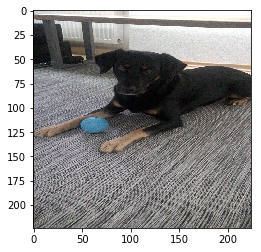

In [8]:

print(image.dtype)
pimage = np.uint8(image)
print(pimage.dtype)
plt.imshow(pimage)
plt.show()

myimages[0] = image


In [9]:
os.chdir("../FacialKeypoint/")

### Load VGG16
Images are loaded into python as correct formats.
Now, we import the VGG16 model. I assume that the followings are available in the current directory.

- vgg16_weights_tf_dim_ordering_tf_kernels.h5
- imagenet_class_index.json

See [my past blog post](https://fairyonice.github.io/Visualization%20of%20Filters%20with%20Keras.html) which discusses where they are downloaded.


In [10]:
from keras.applications import VGG16
model = VGG16(include_top=True,weights=None)
## load the locally saved weights 
model.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels.h5")

### Create an array containing all the 1000 class labels of ImageNet

In [11]:
import json
CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel = []
for i in range(1000):
    classlabel.append(CLASS_INDEX[str(i)][1])
classlabel = np.array(classlabel)
print(len(classlabel))

1000


### Classification 
The following script predict the class label for each image.

##### One note:  RGB to BGR

According to [this](https://github.com/jcjohnson/neural-style/issues/207), 
there are differences in pixel ordering in various modules in python e.g., OpenCV and Matplotlib. 
Here is a note:

- OpenCV: BGR order
- matplotlib: RGB order
- Keras's img_to_array: RGB order
- VGG16: BGR order (because it was created using Caffee which uses OpenCV)

So I need to re order my image array before prediction.

In [12]:
## top 5 selected classes
from copy import copy 
top = 5
prob_string = []
y_preds = []
for image in myimages:
    image = copy(image[:,:,::-1]) ## change order to BGR
    y_pred = model.predict(image.reshape(1,image.shape[0],image.shape[1],image.shape[2])).flatten()
    chosen_classes = classlabel[  np.argsort( y_pred )[::-1][:top] ]
    y_preds.append(y_pred)
    mystrs = ""
    for myclass in chosen_classes:
        myprob = y_pred[classlabel==myclass][0]
        mystr = "{:10} p={:5.3}%\n".format(myclass,myprob*100)
        mystrs += " " + mystr
        #print(mystr)
    prob_string.append(mystrs)

### Plot the images together with the top 5 likely class labels

It seems like VGG16 is doing good jobs for classifing Loki except the second image:
- In all but the second image, Loki is classified into some kind of dog class.
- Loki is not classified into a reasonable dog class in the second picture, probablly because the ImageNet data does not have many data with a dog surrounded by this much snow.

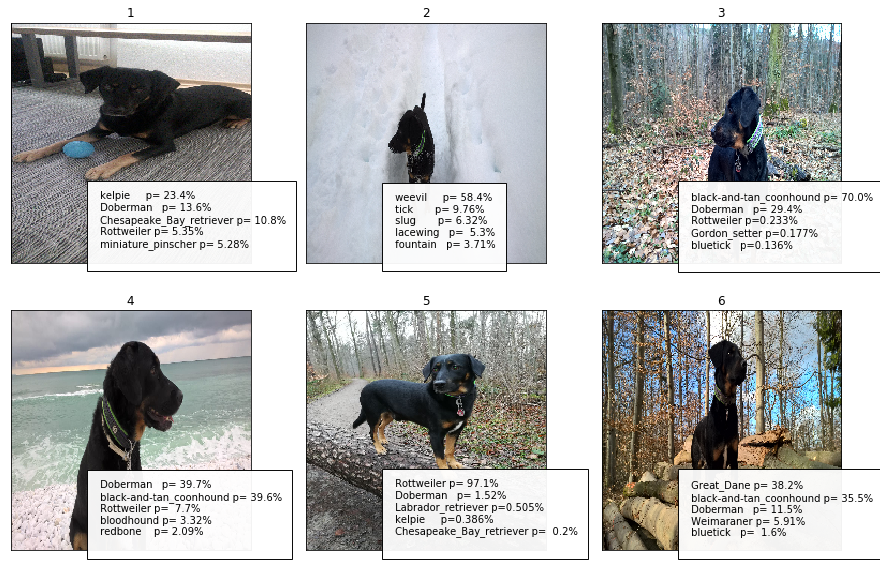

In [13]:
fig = plt.figure(figsize=(15,15))
count = 1

for image,pstr in zip(myimages,prob_string):
    axs = fig.add_subplot(3,len(myimages)/2,count)
    axs.imshow(np.uint8(image))
    axs.set_title(count)
    axs.text(80,220,pstr,
            bbox={'facecolor':'white', 'alpha':0.95, 'pad':10})
    

    axs.set_xticks([])
    axs.set_yticks([])
    count += 1
plt.show()

## So what is the Loki's breed? 
The predicted classes are somewhat different across images. 
To give an overall answer, I will aggregate the probability estimates obtained from all pictures.

In [14]:
y_preds = np.array(y_preds)
y_pred_all = np.mean(y_preds,axis=0)
print("Make sure that the probability sums up to 1: {}".format(np.sum(y_pred_all)))
      

Make sure that the probability sums up to 1: 1.0


## Plot below shows the top 30 overall probabilities for Loki's class.
It seems that Loki is most likely black and tan coonhound.
Loki may be a weevil with 10% chance.

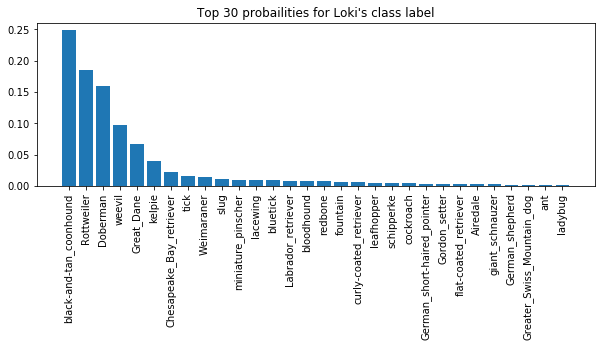

Loki is:
 24.8% black-and-tan_coonhound
 18.6% Rottweiler
 16.0% Doberman
 9.74% weevil
 6.63% Great_Dane
 3.99% kelpie
 2.18% Chesapeake_Bay_retriever
 1.63% tick
  1.4% Weimaraner
 1.05% slug
0.917% miniature_pinscher
0.884% lacewing
0.858% bluetick
0.736% Labrador_retriever
 0.73% bloodhound
0.714% redbone
0.618% fountain
 0.53% curly-coated_retriever
0.514% leafhopper
0.482% schipperke
0.443% cockroach
0.327% German_short-haired_pointer
0.313% Gordon_setter
0.303% flat-coated_retriever
0.282% Airedale
0.278% giant_schnauzer
0.179% German_shepherd
0.172% Greater_Swiss_Mountain_dog
0.165% ant
0.156% ladybug


In [15]:
top = 30
yorder = np.argsort( y_pred_all )[::-1]
classes_reorder = classlabel[ yorder ][:top]
y_pred_reorder  = y_pred_all[ yorder ][:top]
mystrs = ""


xaxis = range(len(y_pred_reorder))
plt.figure(figsize=(10,3))
plt.bar(xaxis,y_pred_reorder)
plt.xticks(xaxis,classes_reorder,rotation=90)
plt.title("Top {} probailities for Loki's class label".format(top))
plt.show()


print("Loki is:")
for p, cl in zip(y_pred_reorder ,classes_reorder):
    print("{:5.3}% {}".format(p*100,cl))